## Data Preparation:
### is the first step to be performed with the data. This process consists of collecting, cleaning, transforming, and manipulating raw data to make it usable for analysis. 

In [9]:
import pandas as pd
import os
import plotly.express as px
import matplotlib as plt

import warnings

warnings.filterwarnings("ignore")

# Dublin Bikes datasets:
    These datasets were collected from data.gov.ie and they are under License: Creative Commons Attribution 4.0 (CC BY 4.0)
    As a total de 12 file were downloaded, this code will read all files and concatenate into a data frame called dublin_hist.


In [10]:
path = "./"
files = [file for file in os.listdir(path) if file.startswith('dublinbike-historical-data-2023') ] # filter only historical data files

dublin_hist = pd.DataFrame()

# for loop will load the file in a dataframe "current_month" and concatenate it to the dataframe "dublin_hist".
for file in files:
    current_month = pd.read_csv(path+"/"+file)
    dublin_hist = pd.concat([dublin_hist, current_month])

dublin_hist.shape

(1923492, 11)

### Extracting Station Name and Location for a new dataframe: dublin_bike_stations
    From the dataset, the bike stations will be extracted buy removing duplicates stations from all hist also, unicessary columns will be removed

In [11]:
dublin_bike_stations = dublin_hist[['STATION ID','NAME','BIKE_STANDS','STATUS','LATITUDE', 'LONGITUDE']].drop_duplicates(subset=["STATION ID"])

dublin_bike_stations.head()

STATION ID                NAME  BIKE_STANDS STATUS  LATITUDE  LONGITUDE
0           1       CLARENDON ROW           31   OPEN   53.3409   -6.26250
1           2  BLESSINGTON STREET           20   OPEN   53.3568   -6.26814
2           3       BOLTON STREET           20   OPEN   53.3512   -6.26986
3           4        GREEK STREET           20   OPEN   53.3469   -6.27298
4           5    CHARLEMONT PLACE           40   OPEN   53.3307   -6.26018

### For proper analysis, only historical data and open station_id will be selected.


In [12]:
# Filtering only OPEN stations and rename columns.
dublin_hist = dublin_hist[dublin_hist['STATUS'] == 'OPEN']

dublin_hist = dublin_hist[['STATION ID', 'TIME', 'BIKE_STANDS', 'AVAILABLE_BIKE_STANDS', 'AVAILABLE_BIKES']]

#rename column AVAILABLE_BIKE_STANDS to BIKES_IN_USE
dublin_hist.rename(columns={'AVAILABLE_BIKE_STANDS': 'BIKES_IN_USE'}, inplace=True)


# Setting the TIME collumn to datetime
dublin_hist['TIME'] = pd.to_datetime(dublin_hist['TIME'])
dublin_hist.head()

STATION ID                TIME  BIKE_STANDS  BIKES_IN_USE  AVAILABLE_BIKES
0           1 2023-01-01 00:00:03           31            31                0
1           2 2023-01-01 00:00:03           20            18                2
2           3 2023-01-01 00:00:03           20             9               11
3           4 2023-01-01 00:00:03           20             8               12
4           5 2023-01-01 00:00:03           40            16               24

# Calculating the number of trips 

    to get the number of  trips, its is necessary to create a for loop, to filter the dataframe by STATION ID and compare the number of BIKES_IN_USE from current row, to the previous row (diff),  if the number of BIKES_IN_USE is  bigger the previous row, so its a new trip otherwise not

In [13]:
# create a empty dataframe to receive the cleaned result
bike_usage = pd.DataFrame()

for i in dublin_bike_stations['STATION ID']:
    # filter by STATION ID 
    fitered = dublin_hist[dublin_hist['STATION ID']== i]

    # Sorting by time
    fitered = fitered.sort_values(by=['TIME'], ascending=True)
    
    # creating a new collumn, "TRIPS" and getting the diff of each row
    fitered["TRIPS"] = fitered["BIKES_IN_USE"].diff()
    
    # Concatenat the new bike_usage dataframe with the filtered dataframe (only with trips)
    bike_usage = pd.concat([bike_usage, fitered[fitered['TRIPS']>0]])



bike_usage.head()

STATION ID                TIME  BIKE_STANDS  BIKES_IN_USE  \
1921           1 2023-01-01 08:30:03           31            31   
2938           1 2023-01-01 13:00:02           31            29   
3390           1 2023-01-01 15:00:03           31            29   
3616           1 2023-01-01 16:00:02           31            29   
3842           1 2023-01-01 17:00:03           31            30   

      AVAILABLE_BIKES  TRIPS  
1921                0    1.0  
2938                2    1.0  
3390                2    1.0  
3616                2    1.0  
3842                1    1.0

# Dublin Bikes Reviews
    For collection of Dublin Bikes Reviews, a tripadvisor API_KEY was created and stored in an .env file
    Tripeadvisor API allow to request only 5 reviews, which were note a significant population to perform Machine Learning Research.
    Due this result a WebScraper Code was generated to scrap reviews from Yelp.
    * Yelp's Terms of Service specifically forbid scraping their website for commercial purposes. However, they do allow scraping for personal, non-commercial and research purposes. 

* TripAdvisor

In [ ]:
from dotenv import load_dotenv
from os import getenv
load_dotenv()
import requests
import json

# Setting Parameters
api_key = getenv('API_KEY')   
location_id = "6439815"   # Dublin Bikes id in TripAdvisor.

url = f"https://api.tripadvisor.com/api/partner/2.0/location/{location_id}/reviews"

headers = {
    "Content-Type": "application/json",
    "X-TripAdvisor-API-Key": api_key, 
}


# This code makes a GET request, If the status code is 200 (Sucess), then it extracts the JSON data from the response and converts it into a pandas DataFrame. 
# If the status code is not 200, then it prints an error message

response = requests.get(url, headers=headers)

if response.status_code == 200:
    
    data = response.json()
    dublin_reviews_df = pd.DataFrame( data['data'])
       
else:
    print(f"Error: {response.status_code}")
    print(response.text)

#print the dataframe:
dublin_reviews_df

* Redit

# Capital BikeShare Dataset
    These datasets were collected from: https://ride.capitalbikeshare.com/system-data and they are under "Capital Bikeshare Data License Agreement"
    As a total de 12 file were downloaded, this code will read all files and concatenate into a data frame called capital_df.



In [14]:

path = "./"
files = [file for file in os.listdir(path) if file.endswith('capitalbikeshare-tripdata.csv') ] # filter only historical data files

capital_df = pd.DataFrame()

# for loop will load the file in a dataframe "current_month" and concatenate it to the dataframe "capital_df".
for file in files:
    current_month = pd.read_csv(path+"/"+file)
    capital_df = pd.concat([capital_df, current_month])

capital_df.shape

(3982701, 13)

### Extracting the Bike Station  location

In [15]:
capital_stations = capital_df[['start_station_id','start_station_name','start_lat','start_lng']].drop_duplicates(subset=["start_station_id"])


# rename the columns name
col_names = {'start_station_id': 'station_id', 'start_station_name': 'station_name', 'start_lat': 'lat','start_lng':'long'}
capital_stations.rename(columns=col_names, inplace=True)

capital_stations.head()

station_id                                       station_name        lat  \
0     31904.0  East Falls Church Metro / Sycamore St & 19th St N  38.885321   
1     32025.0                         Carroll & Westmoreland Ave  38.975000   
2     31276.0                                     15th & L St NW  38.903649   
3     32255.0                             Hartland Rd & Harte Pl  38.878601   
4     32235.0         Merrifield Cinema & Merrifield Town Center  38.870093   

        long  
0 -77.156427  
1 -77.011210  
2 -77.034918  
3 -77.222808  
4 -77.229970

# Cleaning Capital_df dataset

In [16]:
# Find out if is there any duplicated row and null value

print('duplicated rides:' ,capital_df['ride_id'].duplicated().sum())
print('Null Values: \n',capital_df.isnull().sum())

duplicated rides: 0
Null Values: 
 ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    354155
start_station_id      354155
end_station_name      376715
end_station_id        376715
start_lat                  0
start_lng                  0
end_lat                 5453
end_lng                 5453
member_casual              0
dtype: int64


    Not duplicated rides, but there are some Station_id with null values. Its necessary to fix it


In [17]:
null_rows = capital_df[capital_df.isnull().any(axis=1)]
null_rows.head()


ride_id  rideable_type           started_at  \
31   25FF612DB868730D  electric_bike  2023-01-24 13:15:25   
51   0D09AE815D58206D  electric_bike  2023-01-15 20:03:22   
52   B1A26A288A9B8D3A  electric_bike  2023-01-31 06:31:54   
53   9FF759A3244F9810  electric_bike  2023-01-23 11:44:37   
164  0ABA910299ECA1E8  electric_bike  2023-01-06 10:57:47   

                ended_at          start_station_name  start_station_id  \
31   2023-01-24 13:17:26  34th St & Wisconsin Ave NW           31226.0   
51   2023-01-15 20:09:51                         NaN               NaN   
52   2023-01-31 07:04:24                         NaN               NaN   
53   2023-01-23 11:49:34                         NaN               NaN   
164  2023-01-06 11:11:06                         NaN               NaN   

                end_station_name  end_station_id  start_lat  start_lng  \
31                           NaN             NaN  38.916483 -77.068194   
51   Arlington Blvd & N Queen St         31051.0  38.900000 -77.070000   
52                15th & M St NW         31298.0  38.980000 -77.010000   
53                 1st & K St NE         31662.0  38.900000 -77.010000   
164        2nd St & Seaton Pl NE         31522.0  38.900000 -77.030000   

       end_lat    end_lng member_casual  
31   38.910000 -77.070000        casual  
51   38.889365 -77.077294        member  
52   38.905424 -77.034674        member  
53   38.902386 -77.005649        member  
164  38.914751 -77.003560        member

    For this dataset, each row represents one trip, and threre are other rows differente from dublin Bike, as the purpose is to compare both sistems, this dataset will be cleaned to became similar to dublin bikeshare dataset.
    As, the purpose of this project is compare the quantity of riders,  these null values will be replaced by '99999' (Unknown Station)

In [24]:
# each row represents one trip
capital_df['TRIPS']=1
capital_df['start_station_id'].fillna('99999', inplace=True)
capital_df['start_station_id'] = capital_df['start_station_id'].astype(int)





In [23]:
# Set the right  type format of column

capital_df['started_at'] = pd.to_datetime(capital_df['started_at'])
capital_df.info(), display(capital_df.head(2));


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3982701 entries, 0 to 358600
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            object        
 4   start_station_name  object        
 5   start_station_id    float64       
 6   end_station_name    object        
 7   end_station_id      float64       
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: datetime64[ns](1), float64(6), object(6)
memory usage: 425.4+ MB


ride_id rideable_type          started_at             ended_at  \
0  65F0ACD101BF0D49  classic_bike 2023-01-04 19:34:07  2023-01-04 19:39:29   
1  D75158CE73DC43F0  classic_bike 2023-01-27 15:26:38  2023-01-27 19:21:36   

                                  start_station_name  start_station_id  \
0  East Falls Church Metro / Sycamore St & 19th St N           31904.0   
1                         Carroll & Westmoreland Ave           32025.0   

                  end_station_name  end_station_id  start_lat  start_lng  \
0  W Columbia St & N Washington St         32609.0  38.885321 -77.156427   
1        Fenton St & Ellsworth Dr          32036.0  38.975000 -77.011210   

     end_lat    end_lng member_casual  
0  38.885621 -77.166917        member  
1  38.997033 -77.025608        member

# Capital DF Reviews

In [77]:



from dotenv import load_dotenv
from os import getenv
load_dotenv()
import requests
import json

# Setting Parameters
api_key = getenv('API_KEY')   
location_id = "2478701"   # Capital BikeShares id in TripAdvisor.

url = f"https://api.tripadvisor.com/api/partner/2.0/location/{location_id}/reviews"

headers = {
    "Content-Type": "application/json",
    "X-TripAdvisor-API-Key": api_key, 
}


# This code makes a GET request, If the status code is 200 (Sucess), then it extracts the JSON data from the response and converts it into a pandas DataFrame. 
# If the status code is not 200, then it prints an error message

response = requests.get(url, headers=headers)

if response.status_code == 200:
    
    data = response.json()
    capital_reviews_df = pd.DataFrame( data['data'])
       
else:
    print(f"Error: {response.status_code}")
    print(response.text)

#print the dataframe:
capital_reviews_df

id lang location_id            published_date  rating helpful_votes  \
0  930420501   en     2478701  2023-12-20T13:04:20-0500       5             0   
1  925250422   en     2478701  2023-11-09T08:17:18-0500       2             0   
2  922666598   en     2478701  2023-10-23T13:38:59-0400       1             0   
3  922592732   en     2478701  2023-10-23T04:44:24-0400       3             1   
4  921037079   en     2478701  2023-10-12T20:14:40-0400       1             0   

                                    rating_image_url  \
0  https://www.tripadvisor.com/img/cdsi/img2/rati...   
1  https://www.tripadvisor.com/img/cdsi/img2/rati...   
2  https://www.tripadvisor.com/img/cdsi/img2/rati...   
3  https://www.tripadvisor.com/img/cdsi/img2/rati...   
4  https://www.tripadvisor.com/img/cdsi/img2/rati...   

                                                 url trip_type travel_date  \
0  https://www.tripadvisor.com/ShowUserReviews-g2...      None     2023-12   
1  https://www.tripadvisor.com/ShowUserReviews-g2...    Family     2023-11   
2  https://www.tripadvisor.com/ShowUserReviews-g2...      None     2023-10   
3  https://www.tripadvisor.com/ShowUserReviews-g2...      None     2023-10   
4  https://www.tripadvisor.com/ShowUserReviews-g2...      None     2023-09   

                                                text  \
0  My wife and I were recently in Washington DC a...   
1  Attempted to have electronic and or regular bi...   
2  I rented a bike from this company that broke d...   
3  So getting around DC on a bike is great, plent...   
4  Walk, don't bike. Docking stations don't work....   

                                                user  \
0  {'username': 'Leslie H', 'user_location': {'na...   
1  {'username': 'DougD58', 'user_location': {'nam...   
2  {'username': 'Ariana N', 'user_location': {'na...   
3  {'username': 'ashleylY4308RY', 'user_location'...   
4  {'username': 'Wendy T', 'user_location': {'nam...   

                                               title owner_response  
0                             Rideshare, lift E bike           None  
1  Ridiculous and ancient method of bike sharing ...           None  
2  ABSOLUTELY TERRIBLE COMPANY--CHARGED ME $250 F...           None  
3  Convenient and fun but here are some lessons l...           None  
4                                       Walk instead           None

# EDA (Exploratory Data Analysis)  - Understanding the data and patterns

In [25]:
trip_by_station_dublin = bike_usage.groupby(['STATION ID'])['TRIPS'].sum().reset_index()
                         
trip_by_station_dublin_join = pd.merge(trip_by_station_dublin, dublin_bike_stations, how='inner', on='STATION ID').sort_values(by = 'TRIPS', ascending = False).head(10)
trip_by_station_dublin_join[['NAME','TRIPS','BIKE_STANDS']]


NAME    TRIPS  BIKE_STANDS
4                    CHARLEMONT PLACE  18737.0           40
67                   GRAND CANAL DOCK  18707.0           40
32  PRINCES STREET / O'CONNELL STREET  18454.0           23
33                 PORTOBELLO HARBOUR  17076.0           30
8                    EXCHEQUER STREET  16542.0           24
27               MOUNTJOY SQUARE WEST  16459.0           30
13                FOWNES STREET UPPER  16201.0           30
56                  SIR PATRICK DUN'S  16051.0           40
64                   NEW CENTRAL BANK  15738.0           40
66                       HANOVER QUAY  14746.0           40

In [26]:
trip_by_station_capital = capital_df.groupby(['start_station_id'])['TRIPS'].sum().reset_index().sort_values(by='TRIPS', ascending = False)
trip_by_station_capital.head(10)

start_station_id   TRIPS
759             99999  354155
370             31623   40337
167             31229   36007
139             31201   32645
196             31258   30490
348             31600   30086
361             31613   29888
351             31603   29721
185             31247   29014
101             31101   28858

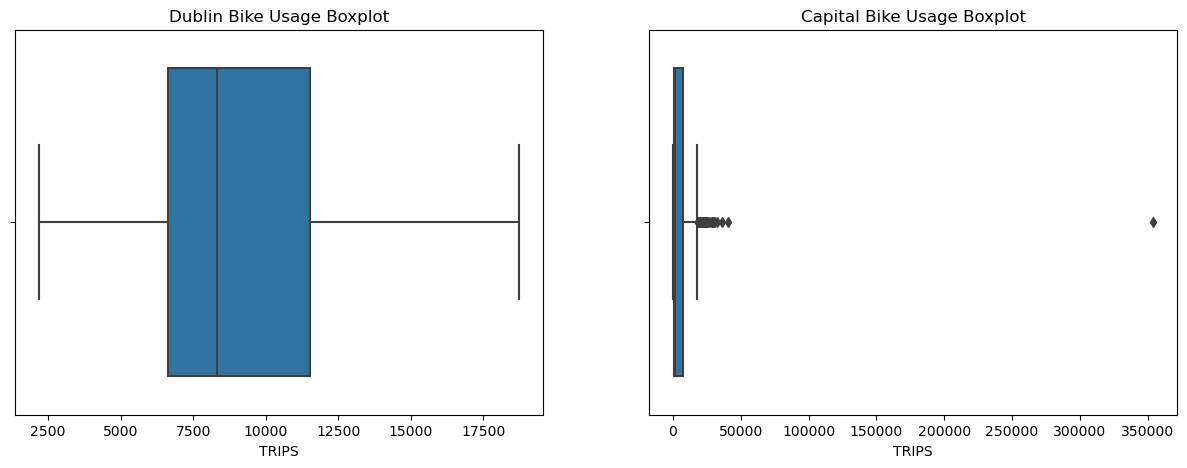

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt


# Group the Dublin data by station ID and calculate the sum of trips
trip_by_station_dublin = bike_usage.groupby(['STATION ID'])['TRIPS'].sum().reset_index()

# Group the Capital data by start_station_id and calculate the sum of trips
trip_by_station_capital = capital_df.groupby(['start_station_id'])['TRIPS'].sum().reset_index()

# Create a new figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the distribution of trips for Dublin data
sns.boxplot(trip_by_station_dublin["TRIPS"], ax=axes[0])
axes[0].set_title("Dublin Bike Usage Boxplot")

# Plot the boxplot of trips for Capital data
sns.boxplot(x=trip_by_station_capital['TRIPS'], ax=axes[1])
axes[1].set_title("Capital Bike Usage Boxplot")

# Show the figure
fig.show()



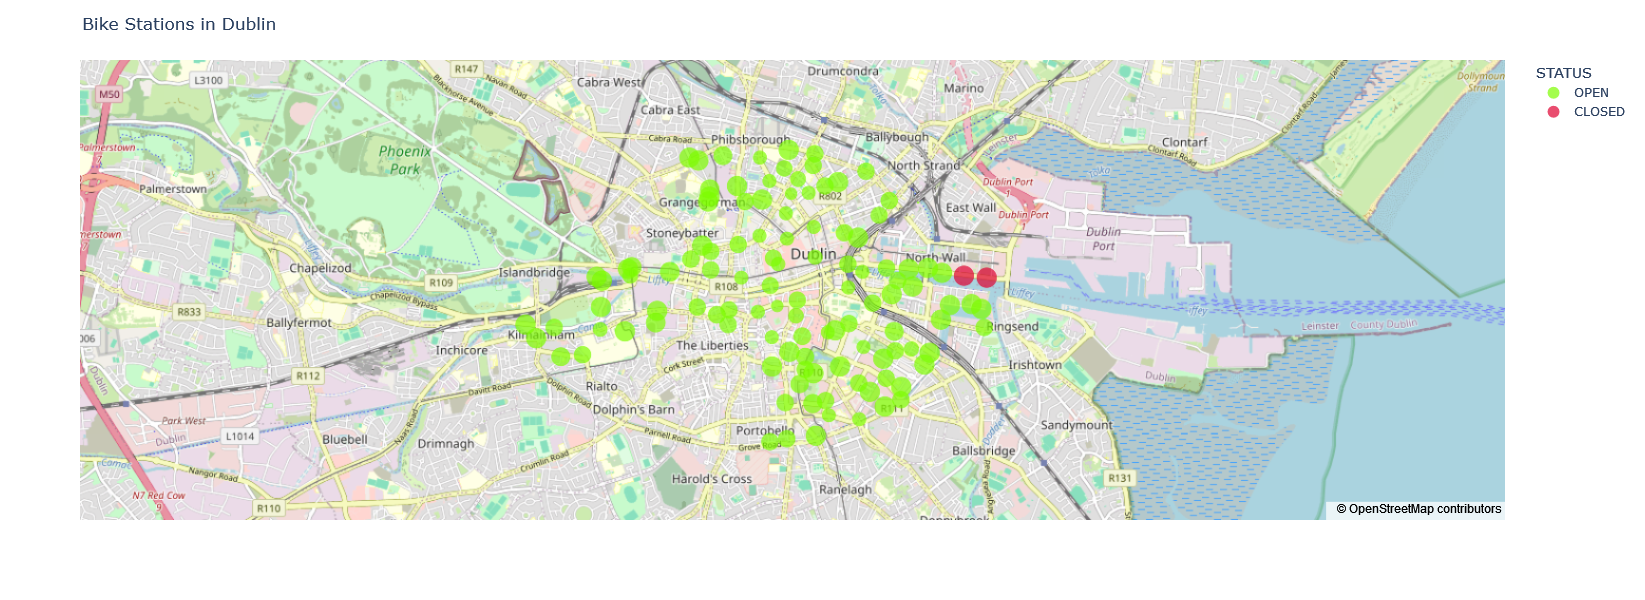

In [28]:
import plotly.express as px
color_mapper = {"OPEN": "#7CFC00", "CLOSED": "#DF0030"}

fig = px.scatter_mapbox(dublin_bike_stations, 
                        lat="LATITUDE",
                        lon="LONGITUDE", 
                        color="STATUS", 
                        size="BIKE_STANDS", 
                        color_discrete_map=color_mapper,
                        size_max=15, 
                        zoom=12, 
                        hover_data=["BIKE_STANDS"],
                        mapbox_style="open-street-map")

# Update layout for larger figure size
fig.update_layout(
    title="Bike Stations in Dublin",
    autosize=False,
    width=1200, 
    height=600,  
)
fig.show()

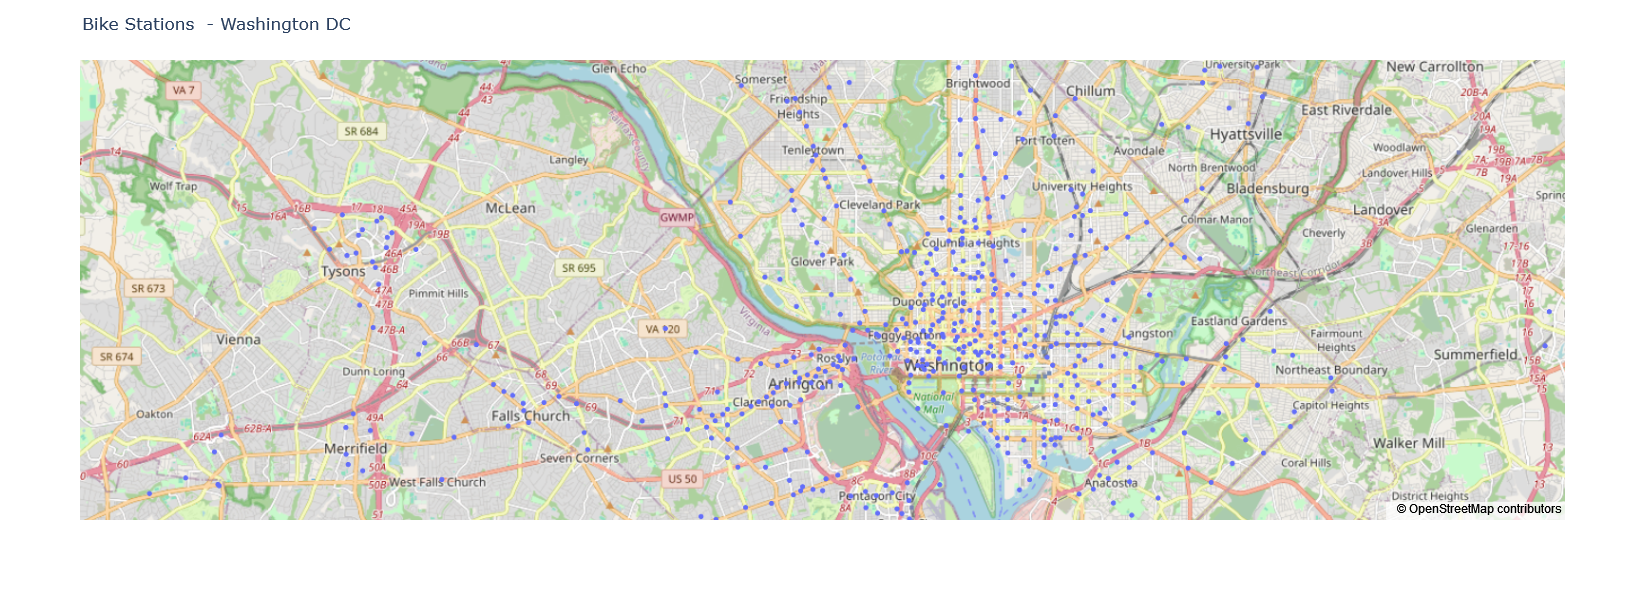

In [94]:
import plotly.express as px


fig = px.scatter_mapbox(capital_stations, 
                        lat="lat",
                        lon="long", 
                        size_max=15, 
                        zoom=12, 
                        hover_data=["station_name"],
                        mapbox_style="open-street-map")

# Update layout for larger figure size
fig.update_layout(
    title="Bike Stations  - Washington DC",
    autosize=False,
    width=1200, 
    height=600,  
)
fig.show()

# Number of trips by weekday and Location
The best approach to perform these chart, is using a dinamic apresentation, and for this purpose, a dashboart using dash and plotly was created

In [29]:
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input,Output
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go



# Prepare the Plot for Dublin
bike_usage['WEEKDAY'] = bike_usage['TIME'].dt.weekday
dublin_weekady = bike_usage.groupby(['WEEKDAY']).agg(BIKE_STANDS=('BIKE_STANDS', 'sum'), 
                                         TRIPS=('TRIPS', 'sum')).reset_index().sort_values('WEEKDAY', ascending=True)
# reneame the weedkday using a mpa 
dublin_weekady['WEEKDAY'] = dublin_weekady['WEEKDAY'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})


# Prepare Weekday dataset
capital_df['WEEKDAY'] = capital_df['started_at'].dt.weekday


capital_weekady = capital_df.groupby(['WEEKDAY']).agg(TRIPS=('TRIPS', 'sum')).reset_index().sort_values('WEEKDAY', ascending=True)


# reneame the weedkday using a mpa 
capital_weekady['WEEKDAY'] = capital_weekady['WEEKDAY'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})


# Build App
app = dash.Dash(__name__)

Location = ['Dublin', "Washingtom DC",]
app.layout = html.Div([
    html.H1("Trips by WeekDay and Location"),
    dcc.Graph(id='graph'),
    
    # create a dropdown
    html.Label([ "Location",
                
            dcc.RadioItems(
            id='day-dropdown',
            # Select the unique days in dataframe
            value='Dublin', options=[
                {'label': loc, 'value': loc}
                for loc in Location
            ]
        )
    ]),
])


# Define callback to update graph
@app.callback(
     
    Output('graph', 'figure'),
    [Input("day-dropdown", "value")]
    
   
)

# Function to return the chreated chart
def update_figure(Location):
    fig = make_subplots(rows=1, cols=2)
    
    # filter the dataframe    
    if Location == "Dublin":
        return px.bar(dublin_weekady, x='WEEKDAY', y='TRIPS', 
                     labels=dict(x='WEEKDAY', y='TRIPS'),
                     title='Bike Usage by Weekday  - Dublin',
                     width = 600, height = 500)
    else:
        
        # Create Plots
        return px.bar(capital_weekady, x='WEEKDAY', y='TRIPS', 
                             labels=dict(x='WEEKDAY', y='TRIPS'),
                             title='Bike Usage by Weekday - Washingtom DC',
                             width = 600, height = 500)
        


        
# Run app and display result inline in the notebook
app.run_server(mode='inline')



# Trips by Month and Location

In [30]:

# Prepare the Plot for Dublin
bike_usage['MONTH'] = bike_usage['TIME'].dt.month
dublin_month = bike_usage.groupby(['MONTH']).agg(TRIPS=('TRIPS', 'sum')).reset_index().sort_values('MONTH', ascending=True)
# reneame the weedkday using a map
dublin_month['MONTH'] = dublin_month['MONTH'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})



# Prepare Weekday dataset
capital_df['MONTH'] = capital_df['started_at'].dt.month


capital_month = capital_df.groupby(['MONTH']).agg(TRIPS=('TRIPS', 'sum')).reset_index().sort_values('MONTH', ascending=True)


# reneame the weedkday using a mpa 
capital_month['MONTH'] = capital_month['MONTH'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})


app = dash.Dash(__name__)


app.layout = html.Div([
    html.H1("Trips by Month and Location"),
    dcc.Graph(id='month'),
    
    # create a dropdown
    html.Label([ "Location",
                
            dcc.RadioItems(
            id='day-dropdown',
            # Select the unique days in dataframe
            value='Dublin', options=[
                {'label': loc, 'value': loc}
                for loc in Location
            ]
        )
    ]),
])


# Define callback to update graph
@app.callback(
     
    Output('month', 'figure'),
    [Input("day-dropdown", "value")]
    
   
)
# Function to return the chreated chart
def update_month(Location):
        
    # filter the dataframe    
    if Location == "Dublin":
        
        return px.bar(dublin_month, x='MONTH', y='TRIPS', 
                     labels=dict(x='MONTH', y='TRIPS'),
                     title='Bike Usage by Month  - Dublin',
                     width = 600, height = 500)
    else:
        
        # Create Plots
        return px.bar(capital_month, x='MONTH', y='TRIPS', 
                             labels=dict(x='MONTH', y='TRIPS'),
                             title='Bike Usage by Month - Washingtom DC',
                             width = 600, height = 500)
        


# Run app and display result inline in the notebook
app.run_server(mode='inline')

        

# 2.0 Statistics for Data Analytics
### Descriptive statistics are a set of tools and techniques used to summarize and describe the key features of a dataset.

### Distribution and Density of Dubin bike_usage Dataframe
    plotting the Distribution of the dataset: “bike_usage”, it represents the bike usage in Dublin Bike System.

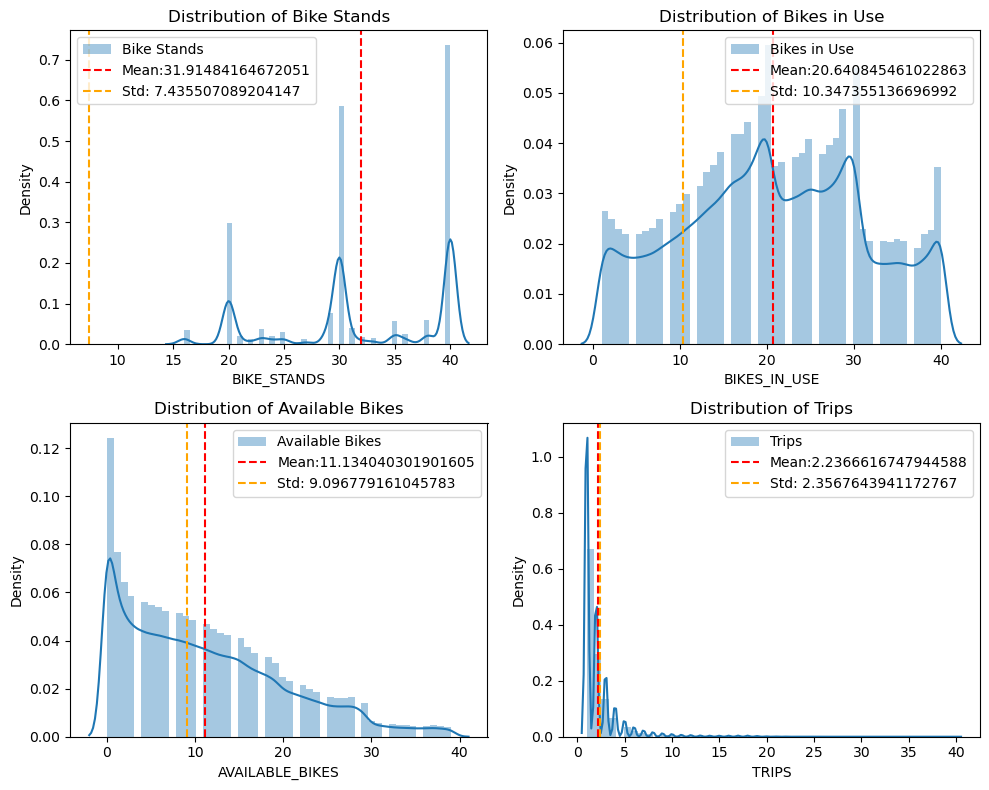

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot the distributions on the subplots

std_dev = bike_usage["BIKE_STANDS"].std()
mean = bike_usage['BIKE_STANDS'].mean()
sns.distplot(bike_usage['BIKE_STANDS'], ax=axes[0, 0], label='Bike Stands')
axes[0, 0].set_title('Distribution of Bike Stands')
axes[0, 0].axvline(bike_usage['BIKE_STANDS'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[0, 0].axvline(bike_usage['BIKE_STANDS'].std(), color='orange', linestyle='--', label= (f'Std: {std_dev}'))
axes[0, 0].legend()



std_dev = bike_usage["BIKES_IN_USE"].std()
mean = bike_usage['BIKES_IN_USE'].mean()                 
sns.distplot(bike_usage['BIKES_IN_USE'], kde=True, ax=axes[0, 1], label='Bikes in Use')
axes[0, 1].set_title('Distribution of Bikes in Use')
axes[0, 1].axvline(bike_usage['BIKES_IN_USE'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[0, 1].axvline(bike_usage['BIKES_IN_USE'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
axes[0, 1].legend()




std_dev = bike_usage["AVAILABLE_BIKES"].std()
mean = bike_usage['AVAILABLE_BIKES'].mean()
sns.distplot(bike_usage['AVAILABLE_BIKES'], kde=True, ax=axes[1, 0], label='Available Bikes')
axes[1, 0].set_title('Distribution of Available Bikes')
axes[1, 0].axvline(bike_usage['AVAILABLE_BIKES'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[1, 0].axvline(bike_usage['AVAILABLE_BIKES'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
axes[1, 0].legend()




std_dev = bike_usage["TRIPS"].std()
mean = bike_usage['TRIPS'].mean()
sns.distplot(bike_usage['TRIPS'], kde=True, ax=axes[1, 1], label='Trips')
axes[1, 1].set_title('Distribution of Trips')
axes[1, 1].axvline(bike_usage['TRIPS'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[1, 1].axvline(bike_usage['TRIPS'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
axes[1, 1].legend()

# Tighten the layout of the subplots
plt.tight_layout()

# Insights
    Distribution of Bike Stands by Density

    The chart shows that the majority of bike stands have a density of between 10 and 25 per unit area. 

    However, there is a small number of stations with a significantly higher or lower number of bike stands than the average. 
    This suggests that there may be a need to redistribute bike stands to ensure that all stations have a similar number of bike stands available.


    Distribution of Bikes in Use

    From the Distribution of Bikes in Use, with a mean of 20.65 and a standard deviation of 10.33, its possible assume that the majority of bikes in use have a usage of between 10.33 and 30.97. There is a smaller number of bikes that are used more or less than this range.
    This suggests that bikes are typically used for a variety of purposes, from short commutes to longer recreational rides..

    Distribution of Available Bikes

    From this chart, its observed that the majority of available bikes have a density of between 10 and 20. Also, there are a smaller number of available bikes with densities below 10 or above 20.
    That means, the available bikes are typically concentrated in certain areas, rather than being evenly distributed throughout the area.


    Distribution of Trips

    The distribution of trips is skewed to the right, with a mean of 2.2 and a standard deviation of 2.35. This indicates that there are more times when there are fewer trips than times when there are more trips.

# Distribution and Density of Trips grouped by station on Both Datasets



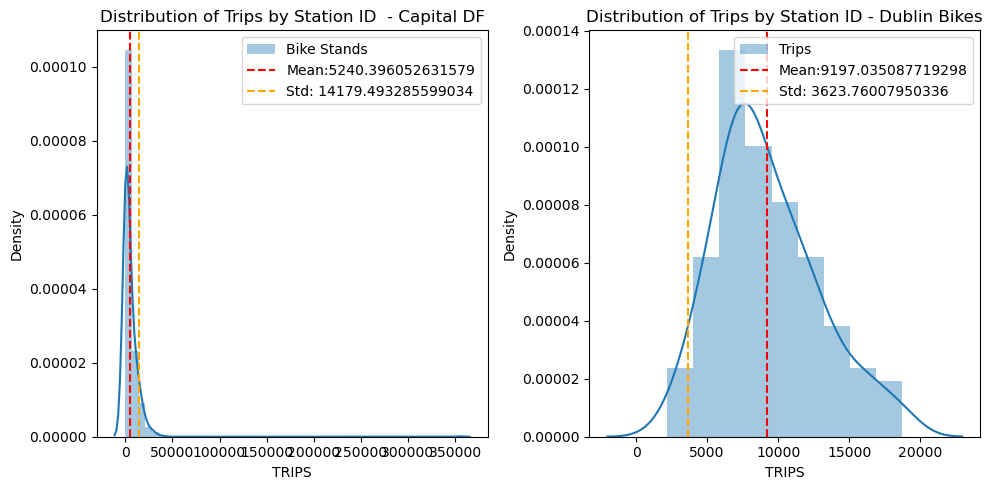

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# grpouping Cpitaol_DF trips by station_id
capital_grp_trips = capital_df.groupby('start_station_id')['TRIPS'].sum().reset_index()

# grpouping Dublin bike_usage df  by station_id
dublin_grp_trips = bike_usage.groupby('STATION ID')['TRIPS'].sum().reset_index()


fig, axes = plt.subplots(1,2, figsize=(10, 5))


# Plot the distributions on the subplots
std_dev = capital_grp_trips["TRIPS"].std()
mean = capital_grp_trips['TRIPS'].mean()               
sns.distplot(capital_grp_trips['TRIPS'], ax=axes[0], label='Bike Stands')
axes[0].set_title('Distribution of Trips by Station ID  - Capital DF')
axes[0].axvline(capital_grp_trips['TRIPS'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[0].axvline(capital_grp_trips['TRIPS'].std(), color='orange', linestyle='--', label= (f'Std: {std_dev}'))
axes[0].legend()


std_dev = dublin_grp_trips["TRIPS"].std()
mean = dublin_grp_trips['TRIPS'].mean()
sns.distplot(dublin_grp_trips['TRIPS'], kde=True, ax=axes[1], label='Trips')
axes[1].set_title('Distribution of Trips by Station ID - Dublin Bikes')
axes[1].axvline(dublin_grp_trips['TRIPS'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[1].axvline(dublin_grp_trips['TRIPS'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
axes[1].legend()


# Tighten the layout of the subplots
plt.tight_layout()

    Its possible to see in both results that the distribution is positively skewed, showing that there are a few stations with a very high number of trips and others stations with a lower number of trips.
    Also, the mean number of trips per station is higher for Capital DF (5240) than for Dublin Bikes (9197), this indicates that the average station in Capital DF has more trips than Dublin Station.


# Correlation between features in Dublin bike_share dataframe


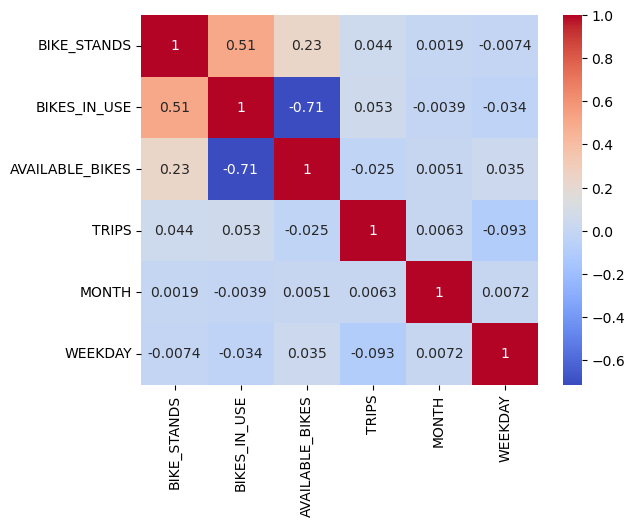

In [99]:
import seaborn as sns
# Correlation between Bike Stands and Bikes in Use
corr = bike_usage[['BIKE_STANDS', 'BIKES_IN_USE', 'AVAILABLE_BIKES', 'TRIPS', 'MONTH', 'WEEKDAY']].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")

plt.show()



# From this correlation heatmap, its possigle to observe these insights. 

    There is a strong negative correlation between BIKE_STANDS and BIKES_IN_USE. This means that as the number of bike stands at a station increases, the number of bikes in use at that station decreases. 
    There is a moderate negative correlation between AVAILABLE_BIKES and TRIPS. This means that as the number of available bikes at a station decreases, the number of bike trips starting  from station increases. 
    there is a very weak correlation between MONTH and TRIPS. This suggests that the number of bike trips does not vary significantly throughout the year.

# Frequency distribution of WeekDay - Comparing Dublin Dataset to Capital_Df

### Dublin bike_usage dataset

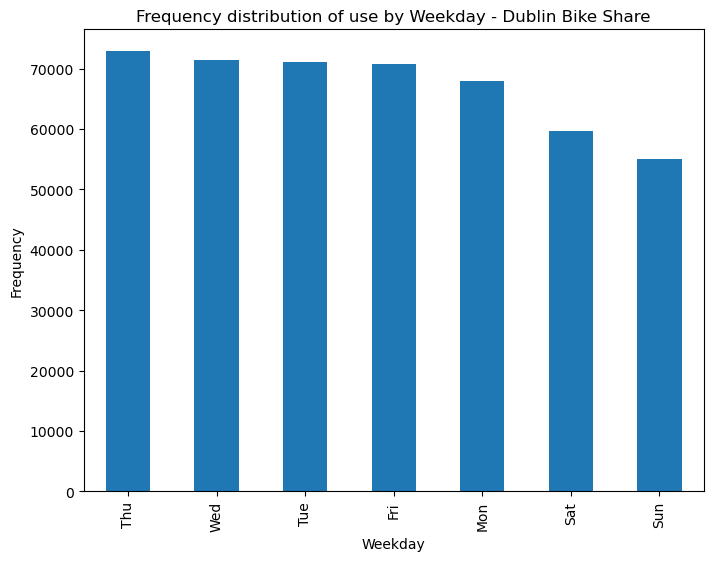

In [100]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
plt.figure(figsize=(8, 6))
bike_usage['WEEKDAY'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}).value_counts().plot(kind='bar')
plt.xlabel('Weekday')
plt.ylabel('Frequency')
plt.title('Frequency distribution of use by Weekday - Dublin Bike Share')

plt.show()

### Capital_df Dataset

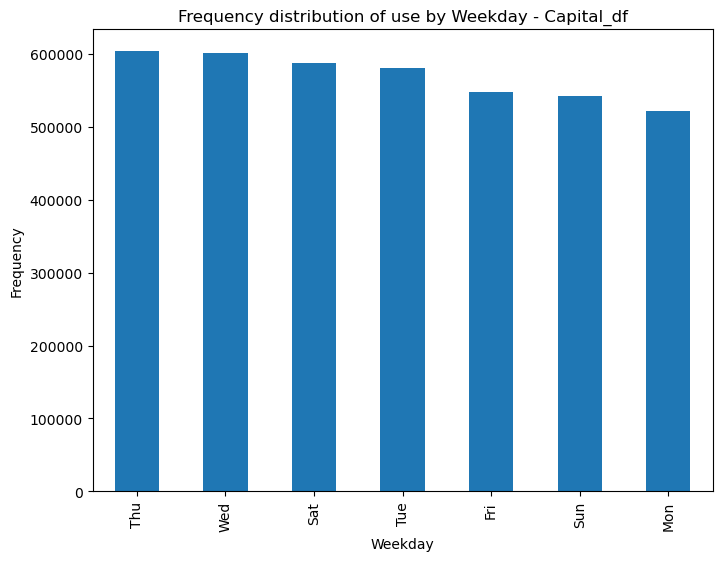

In [101]:

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
capital_df['WEEKDAY'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}).value_counts().plot(kind='bar')
plt.xlabel('Weekday')
plt.ylabel('Frequency')
plt.title('Frequency distribution of use by Weekday - Capital_df')
plt.show()

  # Insights from these plots
    The bike usage in Dublin peaks on Thursdays, with a dip on Sundays, whereas n Capital DF, Thursday is also the most popular weekday, but Monday is the least popular, highlighting that there is a different behavior in each city.

# Inferential Statistics 
    Getting the confidence interval for the population proportion of trips per month.
    
    The population proportion of trips per month is a categorical variable, so we can use the chi-squared test to gain insights into the possible population values.



In [102]:
bike_usage.head(2)

STATION ID                TIME  BIKE_STANDS  BIKES_IN_USE  \
1921           1 2023-01-01 08:30:03           31            31   
2938           1 2023-01-01 13:00:02           31            29   

      AVAILABLE_BIKES  TRIPS  WEEKDAY  MONTH  
1921                0    1.0        6      1  
2938                2    1.0        6      1

# Calculating tht confidence interval for the population proportion of trips per month on both datasets

### Dublin bike_usage Dataset


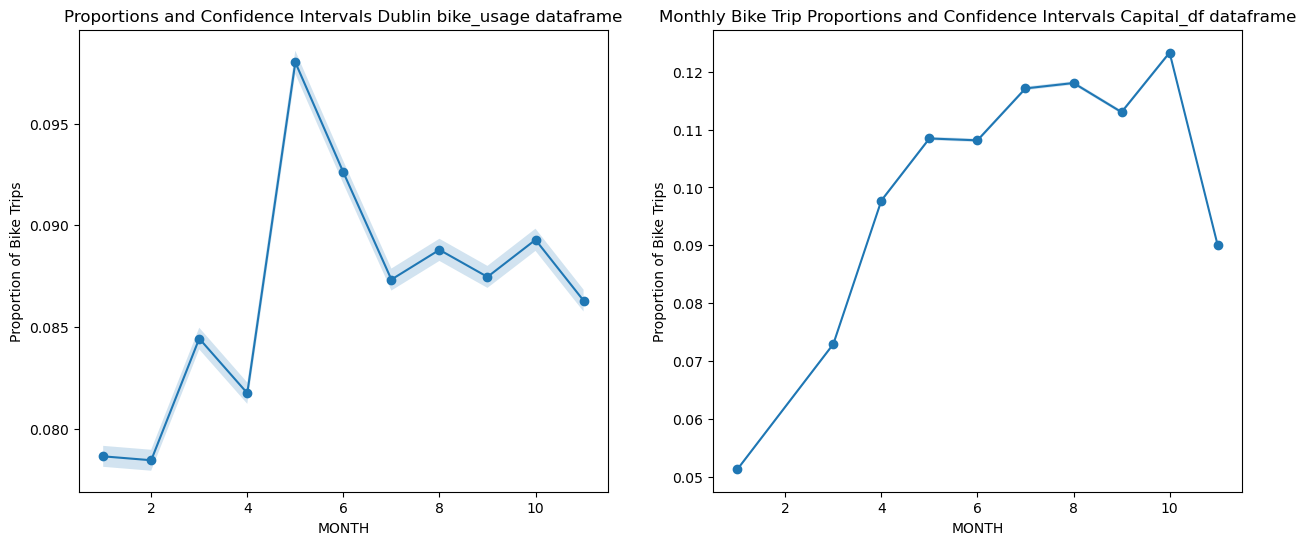

In [103]:
# Import libraries
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6))


# Calculate Proportion of Bike Trips for Each Month - Dublin Bike share Dataset
# --------------------------------------------------------------
monthly_trips =  bike_usage[bike_usage['MONTH']!=12].groupby('MONTH')['TRIPS'].sum()
total_trips =  bike_usage['TRIPS'].sum()
proportions = monthly_trips / total_trips

# Calculate Confidence Intervals for Proportions
conf_intervals = proportion_confint(count=monthly_trips, nobs=total_trips, alpha=0.05, method='normal')

# Create a DataFrame to store the results
results = pd.DataFrame()
results['TRIPS'] = monthly_trips
results['Proportion'] = proportions.values
results['Lower CI'] =  conf_intervals[0]
results['Upper CI'] =  conf_intervals[1]
results = results.reset_index()

  
# Plot the proportion vs month and overlay the confidence intervals

ax0.plot(results['MONTH'], results['Proportion'], marker='o', linestyle='-')
ax0.fill_between(results['MONTH'], results['Lower CI'], results['Upper CI'], alpha=0.2)

# Set labels and title
ax0.set_xlabel('MONTH')
ax0.set_ylabel('Proportion of Bike Trips')
ax0.set_title('Proportions and Confidence Intervals Dublin bike_usage dataframe')

# -------------------------------------------- End Dublin Bike Share Dataset

# Calculate Proportion of Bike Trips for Each Month - Capital DF Dataset
monthly_trips =  capital_df.groupby('MONTH')['TRIPS'].sum()
total_trips =  capital_df['TRIPS'].sum()
proportions = monthly_trips / total_trips

# Calculate Confidence Intervals for Proportions
conf_intervals = proportion_confint(count=monthly_trips, nobs=total_trips, alpha=0.05, method='normal')

# Create a DataFrame to store the results
results = pd.DataFrame()
results['TRIPS'] = monthly_trips
results['Proportion'] = proportions.values
results['Lower CI'] =  conf_intervals[0]
results['Upper CI'] =  conf_intervals[1]
results = results.reset_index()

  
# Plot the proportion vs month and overlay the confidence intervals

ax1.plot(results['MONTH'], results['Proportion'], marker='o', linestyle='-')
ax1.fill_between(results['MONTH'], results['Lower CI'], results['Upper CI'], alpha=0.2)

# Set labels and title
ax1.set_xlabel('MONTH')
ax1.set_ylabel('Proportion of Bike Trips')
ax1.set_title('Monthly Bike Trip Proportions and Confidence Intervals Capital_df dataframe')


plt.show()

# Insights:

    The proportion of bike trips in Dublin varies throughout the year, with the highest proportion of trips occurring in June, July, August.The proportion of bike trips in Dublin has been increasing over time, while the proportion of bike trips in Capidal_DF has remained stable.

### Finding similarities between Dublin (bike_usage) and Washington DC (Capital_Df).
    Applying apply parametric and non-parametric inferential statistical techniques(t-test, analysis of variance, Wilcoxon test, chi-squared test, among others).
    
    #For this purpose, its necessary become both datasets similar eacah other.


In [104]:
capital_df = capital_df[[ 'start_station_id','started_at',  'WEEKDAY', 'MONTH', 'TRIPS'  ]]
bike_usage = bike_usage[[ 'STATION ID', 'TIME', 'WEEKDAY', 'MONTH', 'TRIPS']  ]
display(capital_df.head(2))
display(bike_usage.head(2))

start_station_id          started_at  WEEKDAY  MONTH  TRIPS
0             31904 2023-01-04 19:34:07        2      1      1
1             32025 2023-01-27 15:26:38        4      1      1

STATION ID                TIME  WEEKDAY  MONTH  TRIPS
1921           1 2023-01-01 08:30:03        6      1    1.0
2938           1 2023-01-01 13:00:02        6      1    1.0

# Sampling
    Sampling data is a fundamental practice in statistics and data analysis. When dealing with large populations,

In [105]:
import numpy as np
from scipy.stats import ttest_ind, wilcoxon, chi2_contingency, f_oneway, kruskal

# Randomly sample 20% of bike_usage  dataset
bike_usage_sample = bike_usage.sample(frac=0.05, random_state=42) 
bike_usage_sample.reset_index(drop=True, inplace=True)


# Randomly sample 20% of capital_df dataset
capital_df_sample = capital_df.sample(frac=0.05, random_state=42) 
capital_df_sample.reset_index(drop=True, inplace=True)




# Evaluation of the sample size

    Fof validating the sample size, a ECDFs (Empirical Cumulative Distribution Function) was applied in both dataset



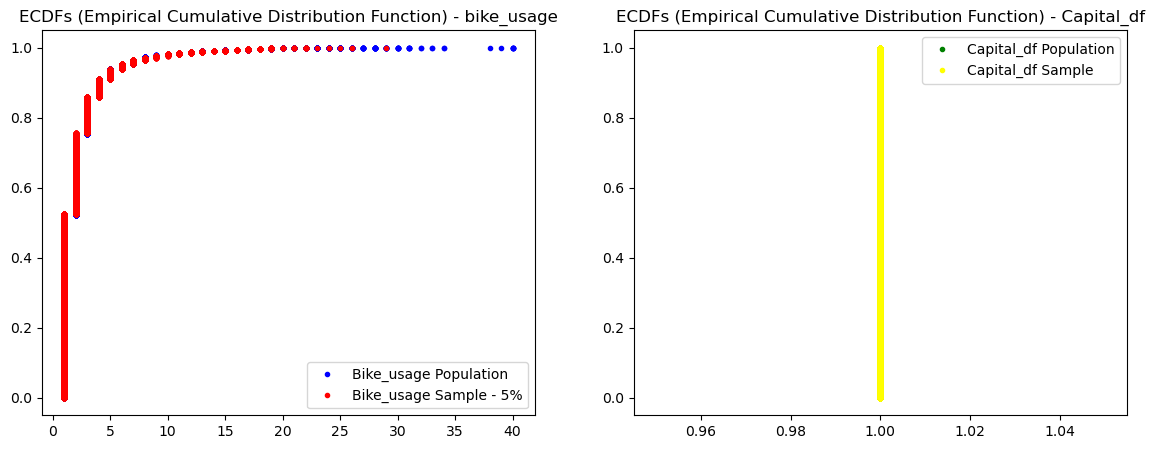

In [106]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y


# ecdf for Dublin bike_usage
d_x_pop, d_y_pop = ecdf(bike_usage['TRIPS'])
d_x_sample, d_y_sample = ecdf(bike_usage_sample['TRIPS'])


# ecdf for Capital DF
c_x_pop, c_y_pop = ecdf(capital_df['TRIPS'])
c_x_sample, c_y_sample = ecdf(capital_df_sample['TRIPS'])

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Empirical Cumulative Distribution Function) - bike_usage
ax0.plot(d_x_pop, d_y_pop, marker='.', linestyle='none', color='blue', label='Bike_usage Population')
ax0.plot(d_x_sample, d_y_sample, marker='.', linestyle='none', color='red', label='Bike_usage Sample - 5%')
ax0.set_title('ECDFs (Empirical Cumulative Distribution Function) - bike_usage' )
ax0.legend()


# Plot Empirical Cumulative Distribution Function) - Capital_df
ax1.plot(c_x_pop, c_y_pop, marker='.', linestyle='none', color='green', label='Capital_df Population')
ax1.plot(c_x_sample, c_y_sample, marker='.', linestyle='none', color='yellow', label='Capital_df Sample')
ax1.set_title('ECDFs (Empirical Cumulative Distribution Function) - Capital_df' )
ax1.legend()

plt.show()


    This sample size of dublin bike_usage doesnt represents the population, it should be increased once the population is much larger than the sample.  so It was applied 20%

In [107]:

import numpy as np
from scipy.stats import ttest_ind, wilcoxon, chi2_contingency, f_oneway, kruskal

# Randomly sample 20% of bike_usage  dataset
bike_usage_sample = bike_usage.sample(frac=0.2, random_state=42) 
bike_usage_sample.reset_index(drop=True, inplace=True)


# Randomly sample 20% of capital_df dataset
capital_df_sample = capital_df.sample(frac=0.2, random_state=42) 
capital_df_sample.reset_index(drop=True, inplace=True)


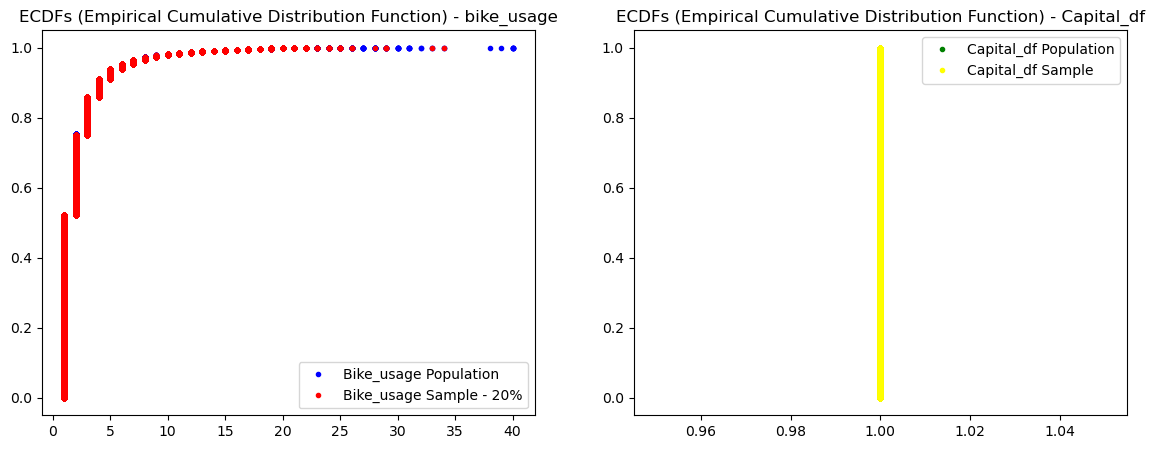

In [108]:

# ecdf for Dublin bike_usage
d_x_pop, d_y_pop = ecdf(bike_usage['TRIPS'])
d_x_sample, d_y_sample = ecdf(bike_usage_sample['TRIPS'])


# ecdf for Capital DF
c_x_pop, c_y_pop = ecdf(capital_df['TRIPS'])
c_x_sample, c_y_sample = ecdf(capital_df_sample['TRIPS'])

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Empirical Cumulative Distribution Function) - bike_usage
ax0.plot(d_x_pop, d_y_pop, marker='.', linestyle='none', color='blue', label='Bike_usage Population')
ax0.plot(d_x_sample, d_y_sample, marker='.', linestyle='none', color='red', label='Bike_usage Sample - 20%')
ax0.set_title('ECDFs (Empirical Cumulative Distribution Function) - bike_usage' )
ax0.legend()


# Plot Empirical Cumulative Distribution Function) - Capital_df
ax1.plot(c_x_pop, c_y_pop, marker='.', linestyle='none', color='green', label='Capital_df Population')
ax1.plot(c_x_sample, c_y_sample, marker='.', linestyle='none', color='yellow', label='Capital_df Sample')
ax1.set_title('ECDFs (Empirical Cumulative Distribution Function) - Capital_df' )
ax1.legend()

plt.show()

# With 20% the sample now is in a good size.

# Parametric Tests:

    Since the data is about trips at different times and stations, A t-test was applied to compare the means of the trips between Dublin and Washington.

In [109]:
# Import necessary libraries
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency

# Parametric Test (t-test)
t_stat, p_val = ttest_ind(bike_usage_sample['TRIPS'], capital_df_sample['TRIPS'])
print(f"T-test: t-statistic = {t_stat}, p-value = {p_val}")

# Conclusion
print("\nConclusions:")
if p_val < 0.05:
    print("There is a significant difference between the two datasets.")
else:
    print("There is no significant difference between the two datasets.")


T-test: t-statistic = 469.9929094326341, p-value = 0.0

Conclusions:
There is a significant difference between the two datasets.


In [110]:
# Non-Parametric Test (Wilcoxon)
u_stat, p_val = mannwhitneyu(bike_usage_sample['TRIPS'], capital_df_sample['TRIPS'])
print(f"Wilcoxon test: U-statistic = {u_stat}, p-value = {p_val}")

# Conclusion
print("\nConclusions:")
if p_val < 0.05:
    print("There is a significant difference between the two datasets.")
else:
    print("There is no significant difference between the two datasets.")


Wilcoxon test: U-statistic = 55207789130.0, p-value = 0.0

Conclusions:
There is a significant difference between the two datasets.


In [111]:
# Chi-Squared Test
# Assuming we want to compare the weekday distribution between the two datasets
contingency_table = pd.crosstab(bike_usage_sample['WEEKDAY'], bike_usage_sample['WEEKDAY'])
chi2, p_val, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Squared Test: Chi2 statistic = {chi2}, p-value = {p_val}")

# Conclusion
print("\nConclusions:")
if p_val < 0.05:
    print("There is a significant difference between the two datasets.")
else:
    print("There is no significant difference between the two datasets.")


Chi-Squared Test: Chi2 statistic = 562512.0, p-value = 0.0

Conclusions:
There is a significant difference between the two datasets.


### Hypothesis: Comparing Bike Usage in Dublin and Washington D.C. During Daytime
    The hypothesis in question posits that Dublin experiences more bike rides during daytime hours compared to Washington D.C.



In [112]:
# to test this hypotesis, its necessary to filter the dataframe by hour.
# Subset data for daytime (6 am to 6 pm)
bike_usage_sample['HOUR'] = bike_usage_sample['TIME'].dt.hour
dublin_group  = bike_usage_sample.groupby(['HOUR'])['TRIPS'].sum().reset_index()
capital_df_sample['HOUR'] = capital_df_sample['started_at'].dt.hour
capital_group = capital_df_sample.groupby(['HOUR'])['TRIPS'].sum().reset_index()


dublin_sample_daytime = dublin_group[(dublin_group['HOUR'] >= 6) & (dublin_group['HOUR'] < 18)]
capital_sample_daytime= capital_group[(capital_group['HOUR'] >= 6) & (capital_group['HOUR'] < 18)]


# Calculate total trips for each city during daytime
total_trips_dublin = dublin_sample_daytime['TRIPS'].sum()
total_trips_capital = capital_sample_daytime['TRIPS'].sum()

print(f"Total trips in Dublin during daytime: {total_trips_dublin}")
print(f"Total trips in Washington D.C. during daytime: {total_trips_capital}")

Total trips in Dublin during daytime: 154411.0
Total trips in Washington D.C. during daytime: 542630


In [113]:
# Hypothesis Testing (comparing means using t-test)
from scipy import stats

t_stat, p_value = stats.ttest_ind(dublin_sample_daytime['TRIPS'], capital_sample_daytime['TRIPS'], equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: Dublin has more bike usage during daytime than Washington D.C.")
else:
    print("Fail to reject the null hypothesis: No significant difference in bike usage during daytime between Dublin and Washington D.C.")

T-statistic: -6.585538607430632
P-value: 2.6198294268193643e-05
Reject the null hypothesis: Dublin has more bike usage during daytime than Washington D.C.


# Machine Learning

## Utilizing Time Series to Test and Predict bike usage in Dublin bikeshare dataset.


    Filter the dataset to apply in a month (november)
    Also, its necessary to create a series object with time(datetime) as index, and sum of trips.

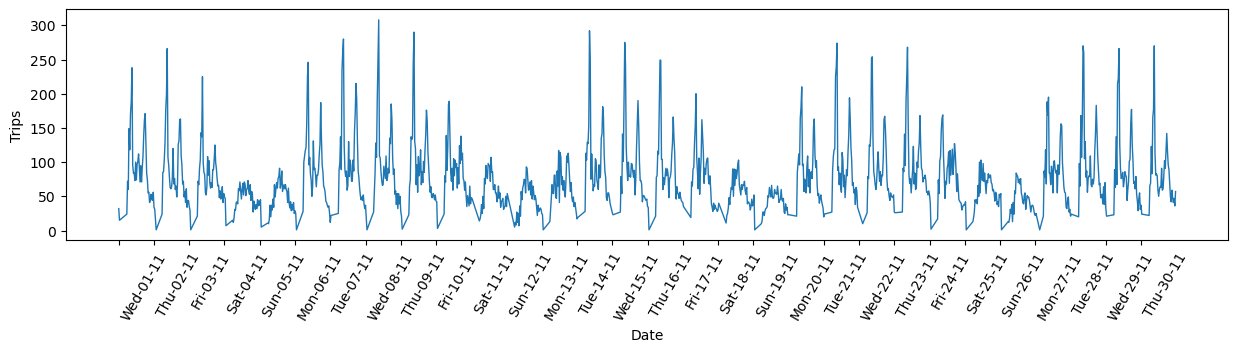

In [31]:
import matplotlib.pyplot as plt


bike_usage_filter = bike_usage[bike_usage['TIME'].dt.month == 11]
bike_series = bike_usage_filter.groupby(['TIME'])['TRIPS'].sum()

# Set the size of the data set
plt.figure(figsize = (15, 3))

# Arrange the data set using date_range() method
xticks = pd.date_range(start = bike_series.index.min(), end = bike_series.index.max(), freq = 'D')

# Set the date format for the plot
#plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation = 60, ha = "left")
plt.xticks(xticks, xticks.strftime("%a-%d-%m"), rotation = 60, ha = "left")

plt.plot(bike_series, linewidth = 1)
plt.xlabel("Date")
plt.ylabel("Trips")
plt.show()

### Function to evaluate and plot the prediction, it use the features, target and regressor, also it uses (70%) of data points for training and the rest for testing


In [66]:
from sklearn.metrics import mean_squared_error


# function to evaluate and plot the prediction, it use the features, target and regressor, also it uses (70%) of data points for training and the rest for testing

def eval_on_features(features, target, regressor):
   
    n_train = round(len(features) * 0.7)
    
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]    
    regressor.fit(X_train, y_train)
       
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    
    # Plotting the chart
    plt.figure(figsize = (15, 3))
    plt.xticks(range(0, len(X), 40), xticks.strftime("%a %m-%d"), rotation = 60, ha = "left")
    plt.plot(range(n_train), y_train, label = "train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label = "test")
    plt.plot(range(n_train), y_pred_train, '--', label = "prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label = "prediction test")
    plt.legend(loc = (1.01, 0))
    plt.title(regressor)
    plt.xlabel("Date")
    plt.ylabel("Trips")
    # End of the chart
    
    
    
    
    # Printting the R^2 and MSE result
    print(f"Model: {regressor}")

    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
        
    mse_test = mean_squared_error(y_test, y_pred)
    print("Test-set MSE: {:.2f}".format(mse_test))
    
    

# Applying RandomForesRegressor over the entire timestamp

Model: RandomForestRegressor(random_state=0)
Test-set R^2: -0.20
Test-set MSE: 2683.33


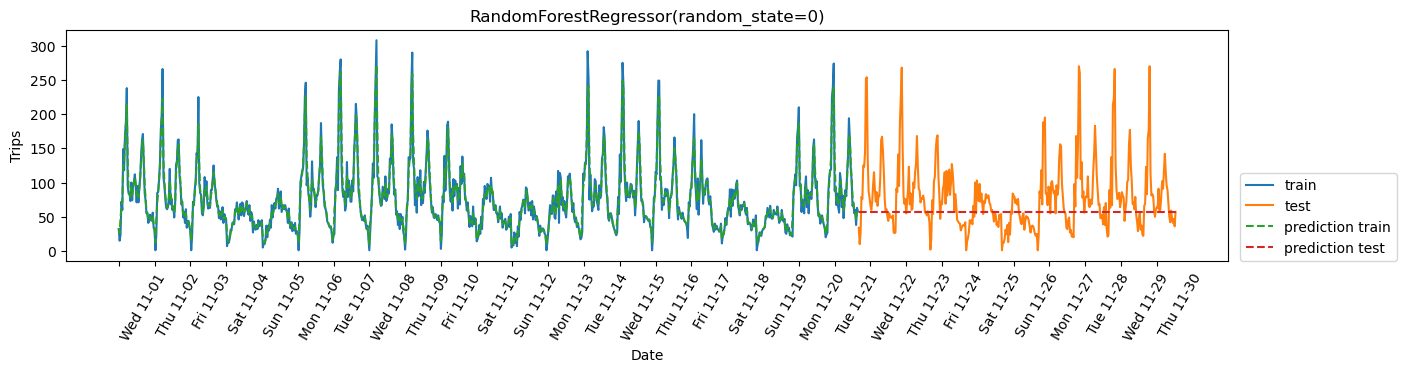

In [67]:

#Extracting the entire timestamp in nanoseconds (POSIX time )
# extract the target values (number of trips)
y = bike_series.values

# convert to POSIX time by dividing by 10**9
X = bike_series.index.astype("int64").values.reshape(-1, 1) // 10**9

from sklearn.ensemble import RandomForestRegressor

# Create an object 'regressor' 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# Call the function eval_on_features() to predict and calculate the R^2  and the mean_squared_error
eval_on_features(X, y, regressor)

    After Applying this model over the entire timestamp, the result was:
    R-squared value of -0.15 shows that its is not a good model, the model performed poorly and it did not explain the variance in the target variable.
    A MSE of 2395.29 ondicates that,the difference between the predicted number of trips and the actual number of trips is high, it shows a larger discrepancy between predicted and actual values.

# Aplying RandomForesRegressor over the Hour of the day

Model: RandomForestRegressor(random_state=0)
Test-set R^2: 0.53
Test-set MSE: 1060.65


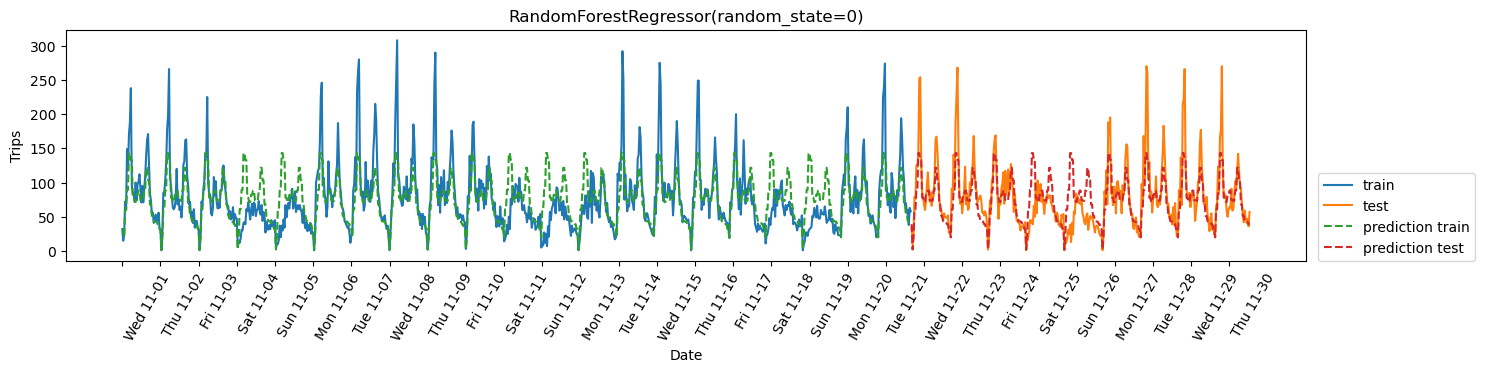

In [61]:
# Store the data hourly in X_hour and make one column using reshape(-1, 1)
X_hour = bike_series.index.hour.values.reshape(-1, 1)

# Call the method eval_on_features() to calculate the R^2  and the mean_squared_erroreval_on_features(X_hour, y, regressor)
eval_on_features(X_hour, y, regressor)

    By using the hour of the day as a feature, the RandomForestRegressor model achieved a moderate fit (R^2 of 0.52) and an average prediction error (MSE of 1010.20). which yet is a poor result.

## Applying RandomForesRegressor over the day of the week and the hour of the day

Model: RandomForestRegressor(random_state=0)
Test-set R^2: 0.81
Test-set MSE: 433.23


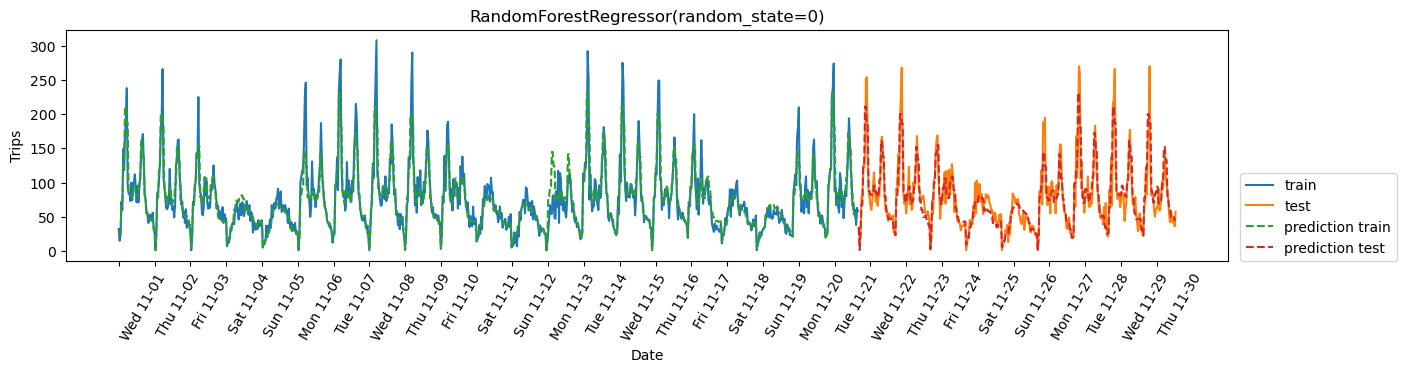

In [69]:
import numpy as np
# Store the hourly data weekly in X_hour_week and make one column using reshape(-1, 1)
X_day_hour_week = np.hstack([bike_series.index.dayofweek.values.reshape(-1, 1), bike_series.index.hour.values.reshape(-1, 1)])

# Call the method eval_on_features() to calculate the R^2  and the mean_squared_erroreval_on_features(X_hour, y, regressor)
eval_on_features(X_day_hour_week, y, regressor)

    By applying both features, day of the week and hour, model achieved better result, a strong fit (0.80) and a reduced the MSE (408.83).
    What means that taking both factores, the model can provide a better prediction of bike trips

# Applying Linear Regression over the day of the week and the hour of the day

Model: LinearRegression()
Test-set R^2: 0.08
Test-set MSE: 2071.39


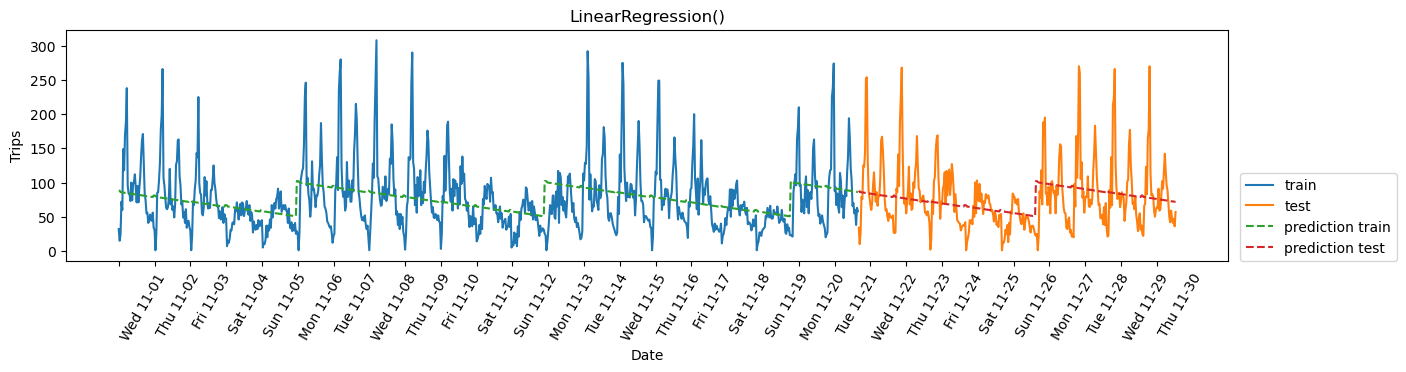

In [70]:
# import LinearRegression library from sklearn
from sklearn.linear_model import LinearRegression

# Call the method eval_on_features() to calculate the R^2  and the mean_squared_erroreval_on_features(X_hour, y, regressor)
eval_on_features(X_day_hour_week, y, LinearRegression())

    By applying linear regression, the model achieved a bad result, R^2 value of 0.08 and a high prediction error MSE of 2071.39.

### Converting categorical data into numerical representation, applying One-hot encoding.
    

In [71]:
# import OneHotEncoder from sklearn
from sklearn.preprocessing import OneHotEncoder

# Declare an object (enc) by calling a method OneHotEncoder()
enc = OneHotEncoder()

# Create an array by calling a fit() method
X_day_hour_week_onehot = enc.fit_transform(X_day_hour_week).toarray()



# Using a combination of polynomial features and ridge regression

Model: Ridge()
Test-set R^2: 0.79
Test-set MSE: 463.64


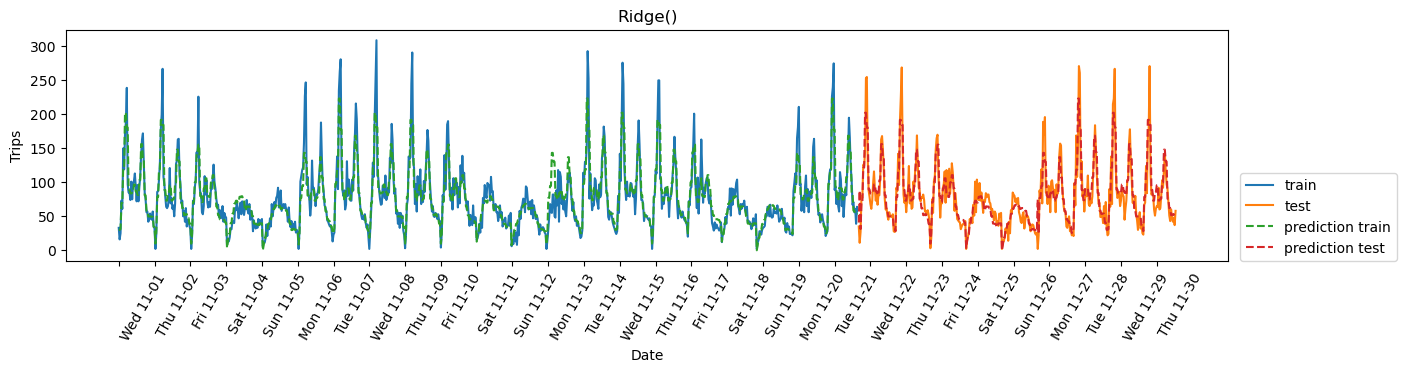

In [72]:
# import polynomial library from sklearn
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

# Create and initialise an object named as PolynomialFeatures()
poly_transformer = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)

# Call fit() method to train the model
X_day_hour_week_onehot_poly = poly_transformer.fit_transform(X_day_hour_week_onehot)

# Initialise an object by calling a method Ridge()
lr = Ridge()

# Call a method eval_on_features() to evaluate R^2 and plot 
eval_on_features(X_day_hour_week_onehot_poly, y, lr)

    By transforming the categorical data into numerical using one-hot encoding and incorporating polynomial features in combination with Ridge regression, the model have improved. With R^2 of 0.79 and  MSE value of 463.64. this model performed similar RandomForesRegressor over the day of the week and the hour of the day.

# Conclusion:
    From these 3 models, its possible to observe that RandomForestRegressor model performed better than other two. The Ridge regression, with its regularization and polynomial features performed similar, but slightly behind the RandomForestRegressor. whereas the LinearRegression model performed worse.


### Woshington D.C Dataset